In [1]:
import pandas as pd
import dotenv
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
import numpy as np
import matplotlib.pyplot as plt

import os
import dotenv

dotenv.load_dotenv()

True

In [2]:
def get_ml_client():
    ml_client = MLClient(
        DefaultAzureCredential(),
        os.getenv("AZURE_SUBSCRIPTION_ID"),
        os.getenv("AZURE_RESOURCE_GROUP"),
        os.getenv("AZURE_ML_WORKSPACE"),
    )
    return ml_client

ml_client = get_ml_client()

In [3]:
def fetch_data() -> pd.DataFrame:
    data = ml_client.data.get(
        name="f1-data",
        version="3",
    )

    return pd.read_csv(data.path)



def split_data(df: pd.DataFrame, seed=42, test_size=0.2):
    train, test = train_test_split(df, test_size=test_size, random_state=seed, stratify=df["year"])
    return train, test

In [4]:
data = fetch_data()
print(data.head())

   raceId  qualifyId  driverId  constructorId  qualifyingPosition  year  \
0      18          1         1              1                   1  2008   
1      18          2         9              2                   2  2008   
2      18          3         5              1                   3  2008   
3      18          4        13              6                   4  2008   
4      18          5         2              2                   5  2008   

   circuitId  positionOrder pointsFinish wonRace podiumFinish  
0          1            1.0         True    True         True  
1          1            9.0        False   False        False  
2          1            5.0         True   False        False  
3          1           13.0        False   False        False  
4          1            2.0         True   False         True  


In [5]:
data.isnull().sum(axis=0)

raceId                 0
qualifyId              0
driverId               0
constructorId          0
qualifyingPosition     0
year                   0
circuitId              0
positionOrder         10
pointsFinish          10
wonRace               10
podiumFinish          10
dtype: int64

In [6]:
# Something weird going on with constructor Marussia in 2015. Let's drop those.
data[data['positionOrder'].isnull()]

,raceId,qualifyId,driverId,constructorId,qualifyingPosition,year,circuitId,positionOrder,pointsFinish,wonRace,podiumFinish
6499,937,6522,829,206,19,2015,13,NaN,NaN,NaN,NaN
6500,937,6523,833,206,20,2015,13,NaN,NaN,NaN,NaN
6578,941,6601,829,206,18,2015,71,NaN,NaN,NaN,NaN
6579,941,6602,833,206,19,2015,71,NaN,NaN,NaN,NaN
6597,942,6620,834,206,18,2015,69,NaN,NaN,NaN,NaN
6598,942,6621,829,206,19,2015,69,NaN,NaN,NaN,NaN
6617,943,6640,834,206,18,2015,32,NaN,NaN,NaN,NaN
6618,943,6641,829,206,19,2015,32,NaN,NaN,NaN,NaN
6637,944,6660,834,206,18,2015,18,NaN,NaN,NaN,NaN
6638,944,6661,829,206,19,2015,18,NaN,NaN,NaN,NaN


In [7]:
data = data.dropna()

* circuitId = ID per location of the race
* raceId = ID per race weekend
* constructorId = ID per car manufacturer
* driverId = ID per driver
* qualifyId = ID per race + driver combination

In [8]:
for col in ['raceId', 'qualifyId', 'driverId', 'constructorId', 'circuitId']:
    print(col, len(data[col].unique()))

raceId 482
qualifyId 10244
driverId 170
constructorId 47
circuitId 43


<Axes: >

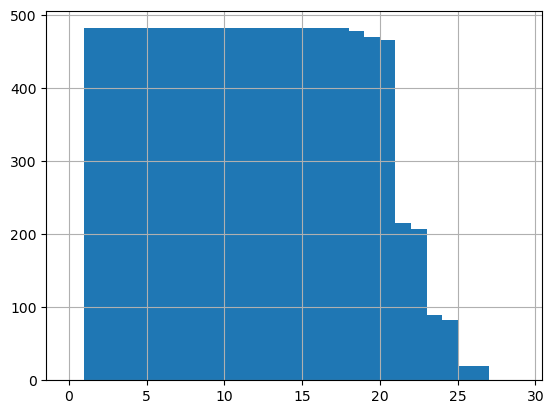

In [9]:
data["qualifyingPosition"].hist(bins=np.arange(30))

<Axes: >

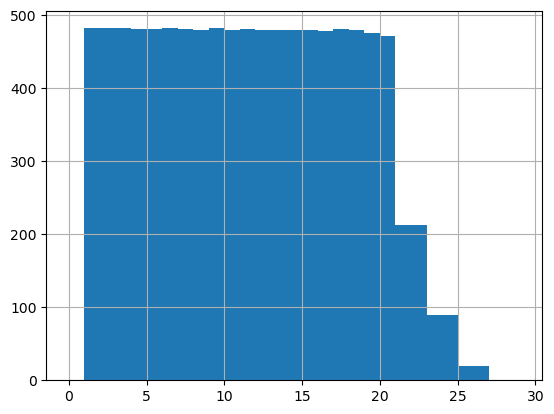

In [10]:
data["positionOrder"].hist(bins=np.arange(30))

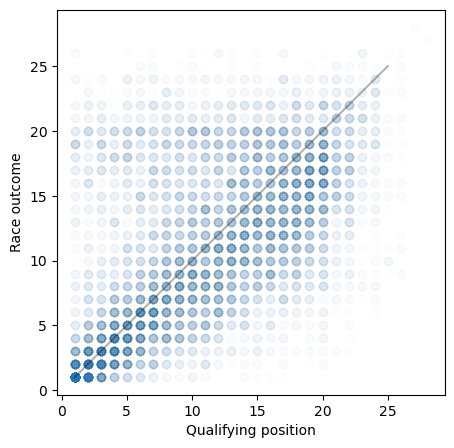

In [11]:
plt.figure(figsize=(5,5))
plt.plot([1,25], [1,25],alpha = 0.3, color='k')

plt.scatter(data["qualifyingPosition"], data["positionOrder"], alpha = 0.01)
plt.xlabel("Qualifying position")
plt.ylabel("Race outcome")
plt.show()

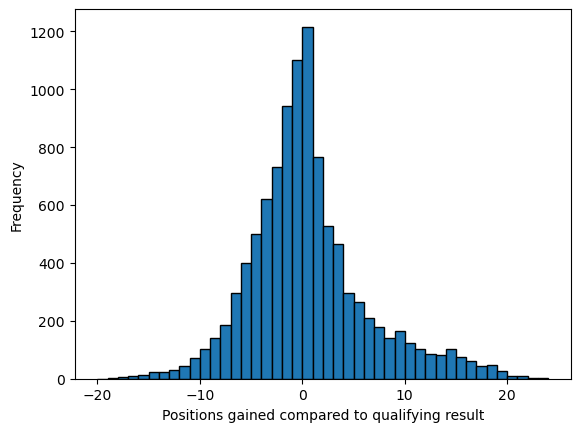

In [12]:
plt.hist(data["positionOrder"] - data["qualifyingPosition"], bins=np.arange(-20, 25),  edgecolor='k')
plt.xlabel("Positions gained compared to qualifying result")
plt.ylabel("Frequency")
plt.show()

In [13]:
CATEGORICAL_COLS = ["constructorId", "year", "driverId", "circuitId"]
NUMERICAL_COLS = ["year", "qualifyingPosition"]
FEATURE_COLS = ["constructorId", "year", "driverId", "circuitId", "qualifyingPosition"]
BOOL_COLS = ["pointsFinish", "wonRace", "podiumFinish"]
TARGET_COLS = ["positionOrder", "pointsFinish", "wonRace", "podiumFinish"]

In [14]:
column_transformer = make_column_transformer(
    (OneHotEncoder(min_frequency=3, handle_unknown="infrequent_if_exist"), CATEGORICAL_COLS),
    (MinMaxScaler(), NUMERICAL_COLS),
)

In [16]:
train, test = split_data(data)

In [17]:
pipeline = make_pipeline(column_transformer, SVC(gamma='auto'))

In [18]:
def get_features_labels(df: pd.DataFrame, target_col: str = 'pointsFinish') -> tuple[pd.DataFrame, pd.DataFrame]:
    return df[FEATURE_COLS], df[target_col].astype(int)

In [19]:
X_train, y_train = get_features_labels(train, target_col="pointsFinish")

In [20]:
y_train.to_numpy()

array([1, 1, 1, ..., 0, 0, 1])

In [21]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=3),
                                                  ['constructorId', 'year',
                                                   'driverId', 'circuitId']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['year',
                                                   'qualifyingPosition'])])),
                ('svc', SVC(gamma='auto'))])

In [22]:
X_test, y_test = get_features_labels(test, target_col="pointsFinish")

In [26]:
pipeline.score(X_test, y_test)

0.7525622254758418